In [199]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from IPython.display import Audio
import time
from pydub import AudioSegment

In [200]:
def generate_vowel(f0 = 120, f1 = 730, f2 = 1090, f3 = 2440, b1 = 100, fs = 16000, pw = 40, dur = 0.5, plot = False):
    
    
    pi = np.pi

    T = 1/fs  #sampling interval
    theta1 = 2 * pi * f1 * T
    theta2 = 2 * pi * f2 * T
    theta3 = 2 * pi * f3 * T
    sigma = b1 * pi * T
    r = np.exp(-sigma)
    
    H1z = signal.dlti([1], [1, -2*r*np.cos(theta1), r**2])
    H2z = signal.dlti([1], [1, -2*r*np.cos(theta2), r**2])
    H3z = signal.dlti([1], [1, -2*r*np.cos(theta3), r**2])
    
    
    samples1, response1 = signal.dimpulse(H1z, t = range(150))
    samples2, response2 = signal.dimpulse(H2z, t = range(150))
    samples3, response3 = signal.dimpulse(H3z, t = range(150))
    
    pulse = signal.windows.triang(pw + 1)  #triangular pulse

    P = int(fs/f0) #period of impulse train
    num_samples = int(fs * dur)
    imp = signal.unit_impulse(num_samples + 1, [x*P for x in range(0,int(num_samples/P) + 1)])

    xn = signal.convolve(pulse, imp)  #source signal - pulse train
    
    h1n = response1[0].reshape(150)
    h2n = response2[0].reshape(150)
    h3n = response3[0].reshape(150)
    
    #Implementation using convolution
    conv1 = signal.convolve(xn, h1n)
    conv2 = signal.convolve(conv1, h2n)
    sn = signal.convolve(conv2, h3n)
    
    if plot:
        plt.figure(figsize = (15,4))
        plt.plot(sn[0:1000])
        plt.title("Sound waveform magnified (zoomed)", fontsize = 18)
        plt.xlabel("n (Sample index)", fontsize = 14)
        plt.ylabel("Amplitude", fontsize = 14)
        plt.show();
    
    return sn, Audio(sn, rate = fs)

In [201]:
generate_vowel(f0 = 120, f1 = 300, f2 = 870, f3 = 2240, plot = False)[1]

In [202]:
sound = generate_vowel(f0 = 120, f1 = 300, f2 = 870, f3 = 2240, plot = False)[0]

In [203]:
from scipy.fft import fft, fftfreq, fftshift

## Finding Window Length in samples

Sampling rate  = 16000 samples/sec = 16 samples/ms

So, 5 ms corresponds to 80 samples

10 ms corresponds to 160 samples and so on

$$ wl (samples) = \frac{f_s (Hz)}{1000}  \times wl (ms) $$ 

In [204]:
def plot_spectrum(f0 = 120, wl_ms = 5, w_shape = 'rectangular'):
    
    sound = generate_vowel(f0 = f0, f1 = 300, f2 = 870, f3 = 2240, plot = False)[0]
    fs = 16000
    wl = int(fs * wl_ms / 1000)
    
    if w_shape == 'hamming':
        window = np.hamming(wl)
        segment = sound[4000:4000+wl] * window
    elif w_shape == 'rectangular':
        segment = sound[4000:4000+wl]
    else:
        print("Invalid window shape")

    dft = np.fft.fft(segment, n = wl * 6)

    freq = np.fft.fftfreq(dft.shape[0], d = 1/16000)

    plt.figure(figsize = (10,4))
#     plt.stem(freq, 20 * np.log10(abs(dft)))
    plt.plot(freq, 20 * np.log(abs(dft)))
    plt.xlim((0,3000))
    plt.xticks([100*x for x in range(31)], rotation = 90)
    plt.axvline(x = 300, color = 'r');
    plt.axvline(x = 870, color = 'r');
    plt.axvline(x = 2240, color = 'r');
    plt.title("Window Length: {}, Window Shape: {}, F0: {} Hz".format(wl_ms, w_shape.title(), f0), fontsize = 15)
    plt.xlabel("Frequency (Hz)", fontsize = 12)
    plt.ylabel("Magnitude (dB)", fontsize = 12)
    plt.grid();

## For F0 = 120 Hz

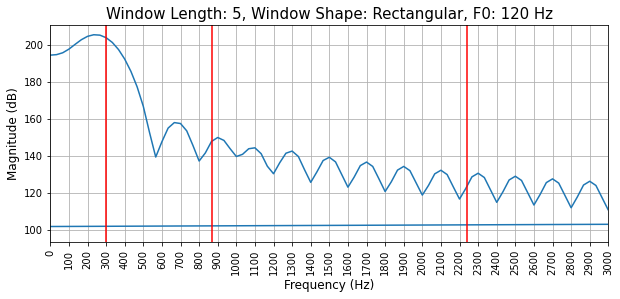

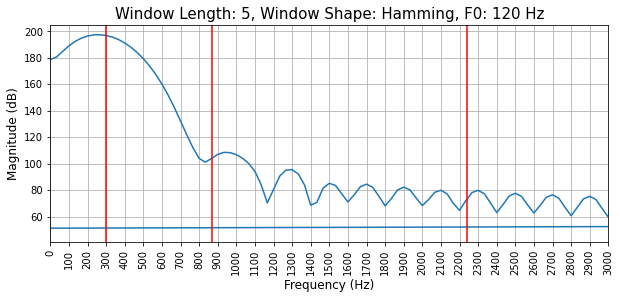

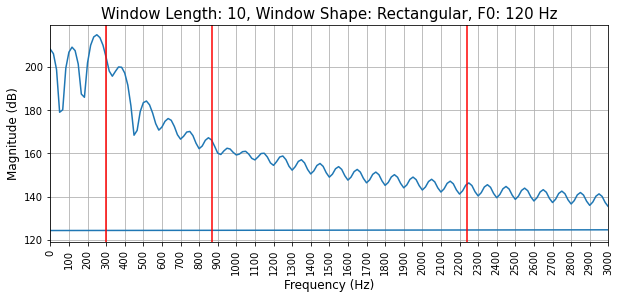

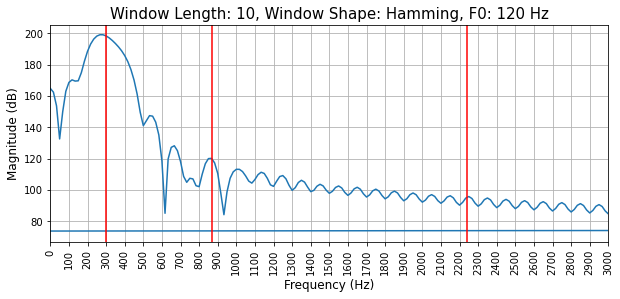

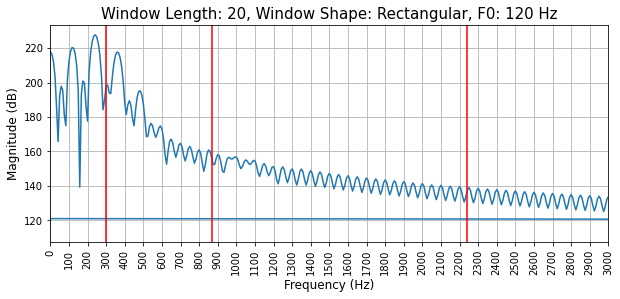

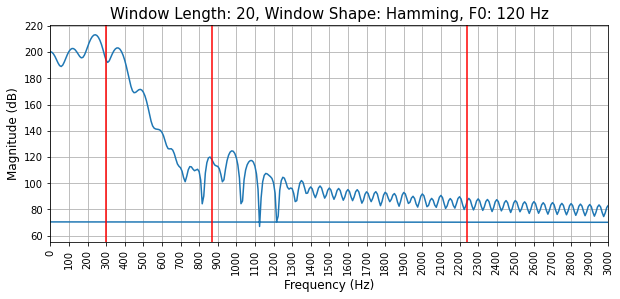

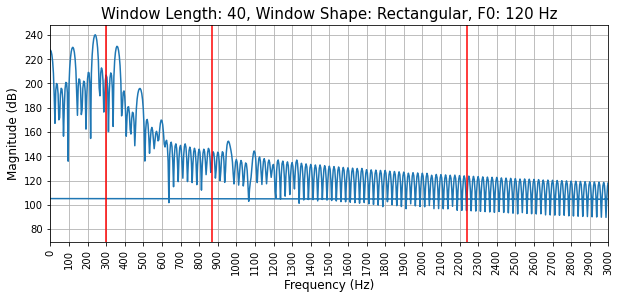

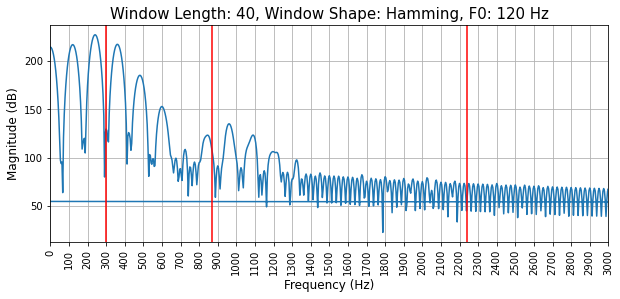

In [205]:
for wl in [5,10,20,40]:    
    for shape in ['rectangular', 'hamming']:
        plot_spectrum(120, wl,shape)

## For F0 = 220 Hz

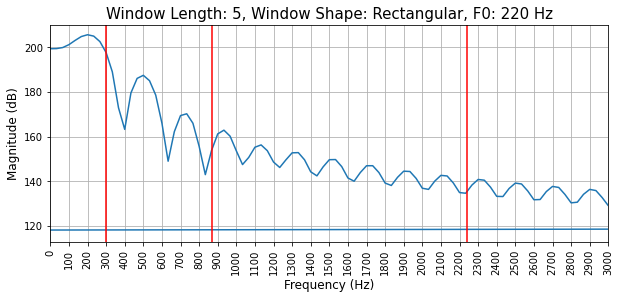

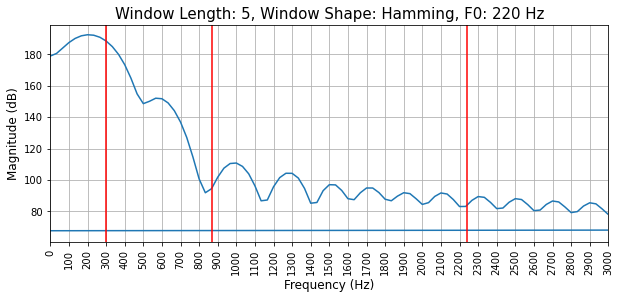

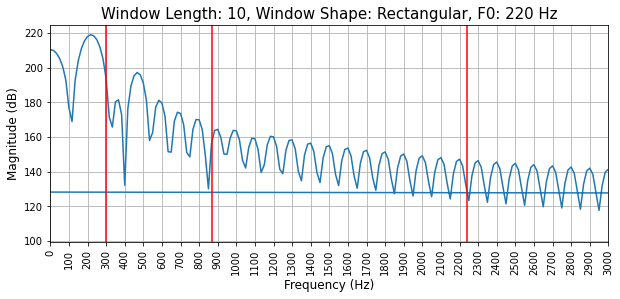

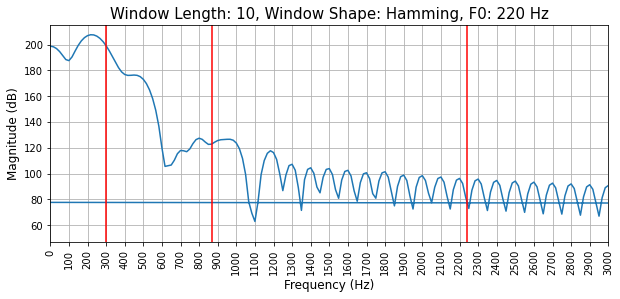

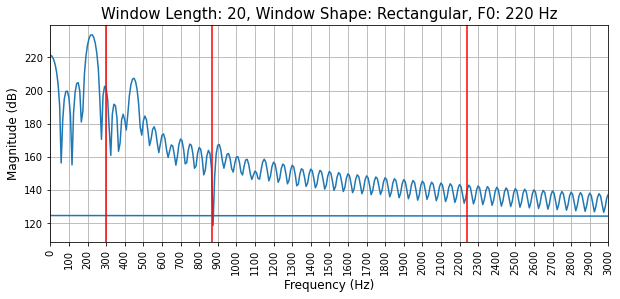

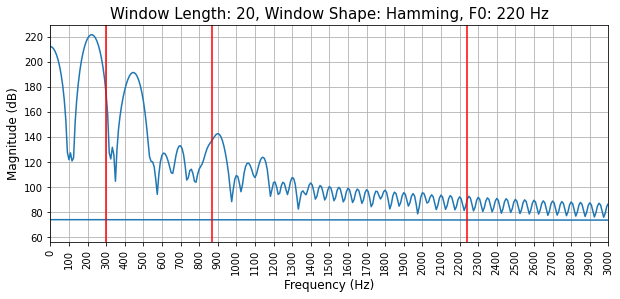

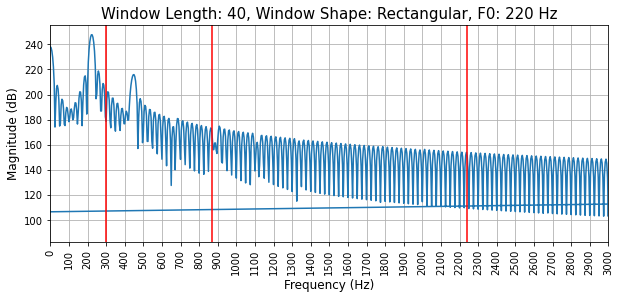

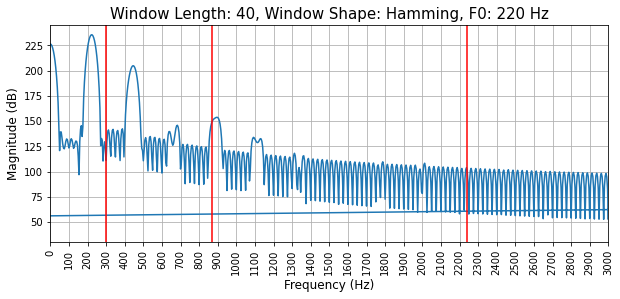

In [206]:
for wl in [5,10,20,40]:
    for shape in ['rectangular', 'hamming']:
        plot_spectrum(220, wl,shape)

## Comment on similarities and differences

**Similarities**: In each spectrum we see that the speech spectrum has a rolloff with increasing frequency. The first peak in the spectrum signifies the first formant, and we get the shape of the hidden envelope of the speech spectrum as expected



**Differences:**

1) W.r.t window shape: The spectrum of the hamming windowed signal gives better information about the formants than the rectangular window. This is because the hamming window has a broader main lobe and less influence because of side lobes. The formants are better visible as "peaks of the peaks" in the spectrum.

2) W.r.t. window length: As we increase the window length, the resolution in the frequency domain increases and we go towards a narrow band spectrum, so we see multiple peaks in the spectrum. The ability to estimate formants is better for the smaller window lengths and the ability to estimate F0 is better for larger window lengths (multiple "peaks")

3) W.r.t fundamental frequency: For higher frequency, the error in the formants seen is high. This is because the formant is "missed" because in a given frequency band, the number of harmonics of the higher frequency is less than that of a lower frequency

## Estimating Signal Parameters

The fundamental frequency F0 can be estimated by seeing the separation between the peaks in the left part of the sprectra. That is because the peaks correspond to the harmonics. We see that for shorter windows, the information cannot be obtained and hence we cannot estimate F0 from the shorter windows (wide band sprectra). 

For the formants, we need to check where the hidden envelope peaks. This information is better obtained in the shorter windows (wide band spectra) than the longer windows (narrow band spectra).

In many of the spectra, the third formant is missed. We need to take even shorter windows for it to be captured and/or lower the frequency of the sound even more so that the formant is not "missed" by the harmonic. 

The estimated formant frequencies and the errors are reported in the following table (figure):

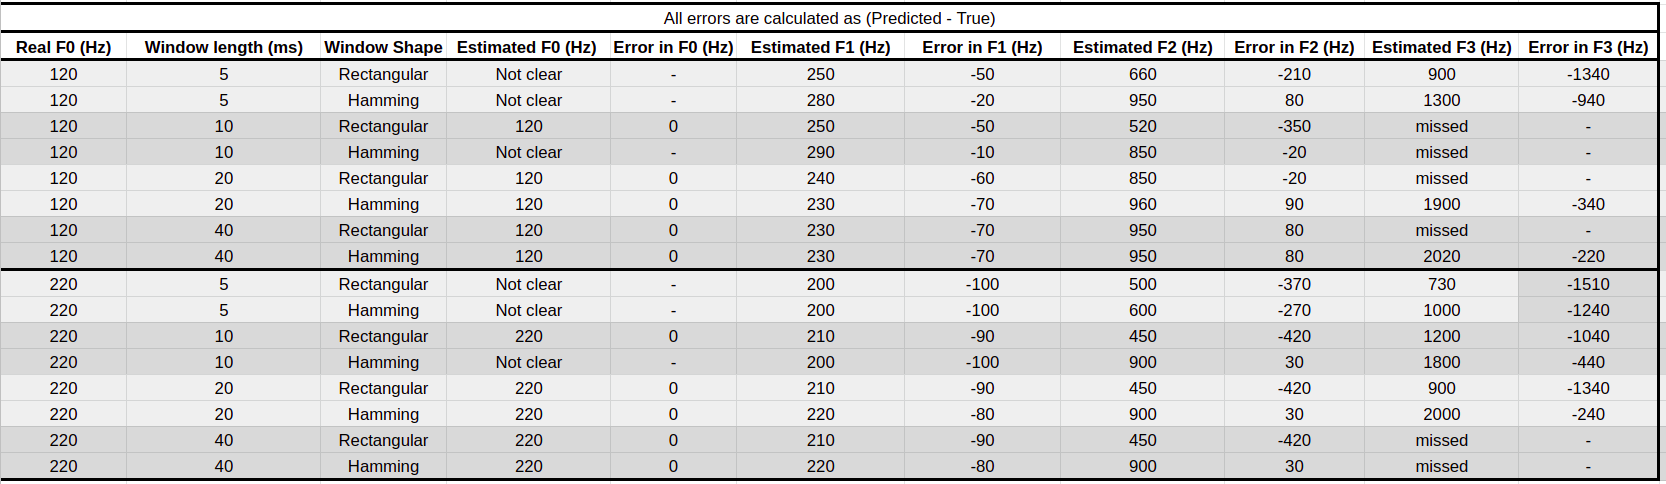